In [1]:
!pip install opencv-python-headless


In [2]:
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload images


Saving car1.jpg to car1.jpg
Saving car2.jpg to car2.jpg
Saving im1.png to im1.png
Saving im2.png to im2.png


In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import convolve as filter2

import os
from argparse import ArgumentParser

In [4]:
def show_image(name, image):
    if image is None:
        return
    cv2.imshow(name, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def get_magnitude(u, v):
    scale = 3
    sum = 0.0
    counter = 0.0

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1],8):
            counter += 1
            dy = v[i,j] * scale
            dx = u[i,j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            sum += magnitude

    mag_avg = sum / counter
    return mag_avg


In [5]:
def draw_quiver(u, v, beforeImg):
    scale = 3
    ax = plt.figure().gca()
    ax.imshow(beforeImg, cmap='gray')

    magnitudeAvg = get_magnitude(u, v)

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1], 8):
            dy = v[i, j] * scale
            dx = u[i, j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            # draw only significant changes
            if magnitude > magnitudeAvg:
                ax.arrow(j, i, dx, dy, color='red')

    plt.draw()
    plt.show()


In [6]:
def get_derivatives(img1, img2):
    x_kernel = np.array([[-1, 1], [-1, 1]]) * 0.25
    y_kernel = np.array([[-1, -1], [1, 1]]) * 0.25
    t_kernel = np.ones((2, 2)) * 0.25

    fx = filter2(img1, x_kernel) + filter2(img2, x_kernel)
    fy = filter2(img1, y_kernel) + filter2(img2, y_kernel)
    ft = filter2(img1, -t_kernel) + filter2(img2, t_kernel)

    return [fx, fy, ft]


In [8]:
def read_flow(file):
    with open(file, 'rb') as f:
        f.read(4)  # Skip the magic number
        width = np.fromfile(f, np.int32, 1)[0]
        height = np.fromfile(f, np.int32, 1)[0]
        flow = np.fromfile(f, np.float32, count=2 * width * height)
        flow = flow.reshape((height, width, 2))
    return flow[..., 0], flow[..., 1]  # u, v components

In [9]:
def computeHS(name1, name2, alpha, delta):
    beforeImg = cv2.imread(name1, cv2.IMREAD_GRAYSCALE)
    afterImg = cv2.imread(name2, cv2.IMREAD_GRAYSCALE)


    if beforeImg is None:
        raise NameError("Can't find image: \"" + name1 + '\"')
    elif afterImg is None:
        raise NameError("Can't find image: \"" + name2 + '\"')

    beforeImg = beforeImg.astype(float)
    afterImg = afterImg.astype(float)

    # Removing noise with Gaussian blur
    beforeImg = cv2.GaussianBlur(beforeImg, (5, 5), 0)
    afterImg = cv2.GaussianBlur(afterImg, (5, 5), 0)

    # Initialize flow vectors
    u = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))
    v = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))

    fx, fy, ft = get_derivatives(beforeImg, afterImg)

    avg_kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                           [1 / 6, 0, 1 / 6],
                           [1 / 12, 1 / 6, 1 / 12]], float)

    iter_counter = 0
    while True:
        iter_counter += 1
        u_avg = filter2(u, avg_kernel)
        v_avg = filter2(v, avg_kernel)
        p = fx * u_avg + fy * v_avg + ft
        d = 4 * alpha**2 + fx**2 + fy**2
        prev = u

        u = u_avg - fx * (p / d)
        v = v_avg - fy * (p / d)

        diff = np.linalg.norm(u - prev, 2)

        # Convergence check (at most 300 iterations)
        if diff < delta or iter_counter > 300:
            break

    # Visualize the results
    draw_quiver(u, v, beforeImg)

    return [u, v]


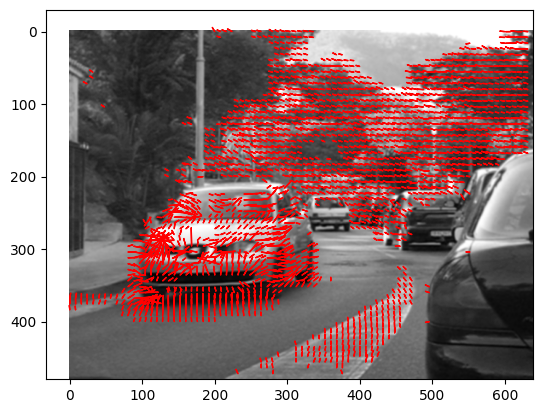

In [10]:
u, v = computeHS('car1.jpg', 'car2.jpg', alpha=15, delta=10**-1)

In [11]:
def computeHSwithMedian(name1, name2, alpha, delta):
    beforeImg = cv2.imread(name1, cv2.IMREAD_GRAYSCALE)
    afterImg = cv2.imread(name2, cv2.IMREAD_GRAYSCALE)

    if beforeImg is None:
        raise NameError("Can't find image: \"" + name1 + '\"')
    elif afterImg is None:
        raise NameError("Can't find image: \"" + name2 + '\"')

    beforeImg = beforeImg.astype(float)
    afterImg = afterImg.astype(float)

    # Removing noise with Gaussian blur
    beforeImg = cv2.GaussianBlur(beforeImg, (5, 5), 0)
    afterImg = cv2.GaussianBlur(afterImg, (5, 5), 0)

    # Initialize flow vectors
    u = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))
    v = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))

    fx, fy, ft = get_derivatives(beforeImg, afterImg)

    avg_kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                           [1 / 6, 0, 1 / 6],
                           [1 / 12, 1 / 6, 1 / 12]], float)

    iter_counter = 0
    while True:
        iter_counter += 1
        u_avg = filter2(u, avg_kernel)
        v_avg = filter2(v, avg_kernel)
        p = fx * u_avg + fy * v_avg + ft
        d = 4 * alpha**2 + fx**2 + fy**2
        prev = u

        u = u_avg - fx * (p / d)
        v = v_avg - fy * (p / d)

        # Apply median filtering to the flow field
        u = cv2.medianBlur(u.astype(np.float32), 5)
        v = cv2.medianBlur(v.astype(np.float32), 5)

        diff = np.linalg.norm(u - prev, 2)

        # Convergence check (at most 300 iterations)
        if diff < delta or iter_counter > 300:
            break

    # Visualize the results
    draw_quiver(u, v, beforeImg)

    return [u, v]


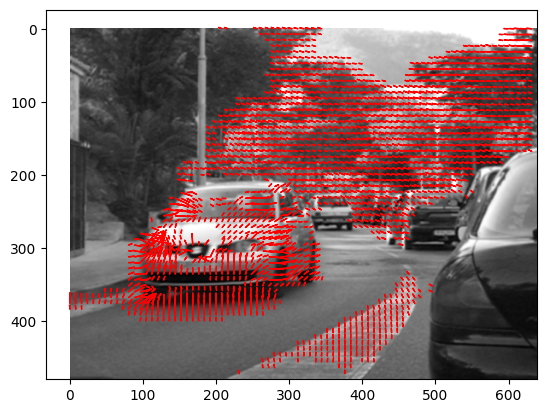

In [12]:
u, v = computeHSwithMedian('car1.jpg', 'car2.jpg', alpha=15, delta=10**-1)

In [13]:
def computeWithNewObjective(name1, name2, alpha, delta, lambda_2=0.1):
    beforeImg = cv2.imread(name1, cv2.IMREAD_GRAYSCALE)
    afterImg = cv2.imread(name2, cv2.IMREAD_GRAYSCALE)

    if beforeImg is None:
        raise NameError("Can't find image: \"" + name1 + '\"')
    elif afterImg is None:
        raise NameError("Can't find image: \"" + name2 + '\"')

    beforeImg = beforeImg.astype(float)
    afterImg = afterImg.astype(float)

    # Removing noise with Gaussian blur
    beforeImg = cv2.GaussianBlur(beforeImg, (5, 5), 0)
    afterImg = cv2.GaussianBlur(afterImg, (5, 5), 0)


    # Set up initial values
    u = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))
    v = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))
    u_hat = np.zeros_like(u)  # Auxiliary flow field u
    v_hat = np.zeros_like(v)  # Auxiliary flow field v
    fx, fy, ft = get_derivatives(beforeImg, afterImg)
    avg_kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                            [1 / 6, 0, 1 / 6],
                            [1 / 12, 1 / 6, 1 / 12]], float)

    iter_counter = 0

    while True:
        iter_counter += 1
        u_avg = filter2(u, avg_kernel)
        v_avg = filter2(v, avg_kernel)
        p = fx * u_avg + fy * v_avg + ft
        d = 4 * alpha**2 + fx**2 + fy**2
        prev_u = u.copy()
        prev_v = v.copy()

        # Update flow fields with auxiliary field penalty
        u = u_avg - fx * (p / d) - lambda_2 * (u - u_hat)
        v = v_avg - fy * (p / d) - lambda_2 * (v - v_hat)

        # Update auxiliary fields with non-local smoothness (median filter)
        u_hat = cv2.medianBlur(u.astype(np.float32), 5)
        v_hat = cv2.medianBlur(v.astype(np.float32), 5)

        # Convergence check
        diff_u = np.linalg.norm(u - prev_u, 2)
        diff_v = np.linalg.norm(v - prev_v, 2)

        if max(diff_u, diff_v) < delta or iter_counter > 300:
            break

    # Visualize the results
    draw_quiver(u, v, beforeImg)

    return [u, v]


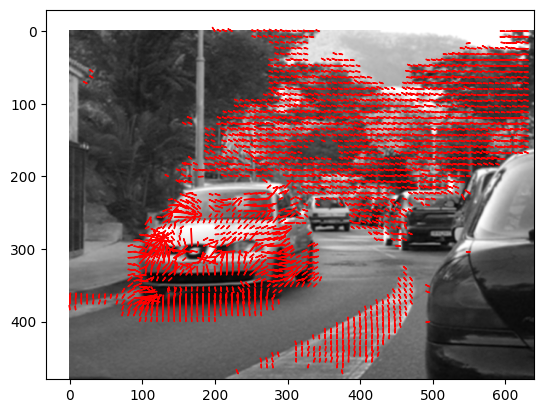

In [14]:
u, v = computeWithNewObjective('car1.jpg', 'car2.jpg', alpha=15, delta=10**-1)